In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics
from sklearn.model_selection import train_test_split

import os

import datetime

import seaborn as sns
from tqdm.notebook import tqdm
torch.manual_seed(17)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/"

In [ ]:
train_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/train"
val_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/val"
test_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/test"

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

In [ ]:
train_dataset = datasets.ImageFolder(
                              root = train_path,
                              transform = image_transforms["train"]
                       )

val_dataset = datasets.ImageFolder(
                              root = val_path,
                              transform = image_transforms["train"]
                       )

test_dataset = datasets.ImageFolder(
                              root = test_path,
                              transform = image_transforms["train"]
                       )

In [ ]:
print("Training length: ", len(train_dataset))
print("Validation length: ", len(val_dataset))
print("Testing length: ", len(test_dataset))

Training length:  11964
Validation length:  2279
Testing length:  910


In [ ]:
train_idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}
val_idx2class = {v: k for k, v in val_dataset.class_to_idx.items()}
test_idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}

In [ ]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict


In [ ]:
train_dist = get_class_distribution(train_dataset, train_idx2class)
val_dist = get_class_distribution(val_dataset, val_idx2class)
test_dist = get_class_distribution(test_dataset, test_idx2class)

Text(0.5, 1.0, 'Train Set Class Distribution')

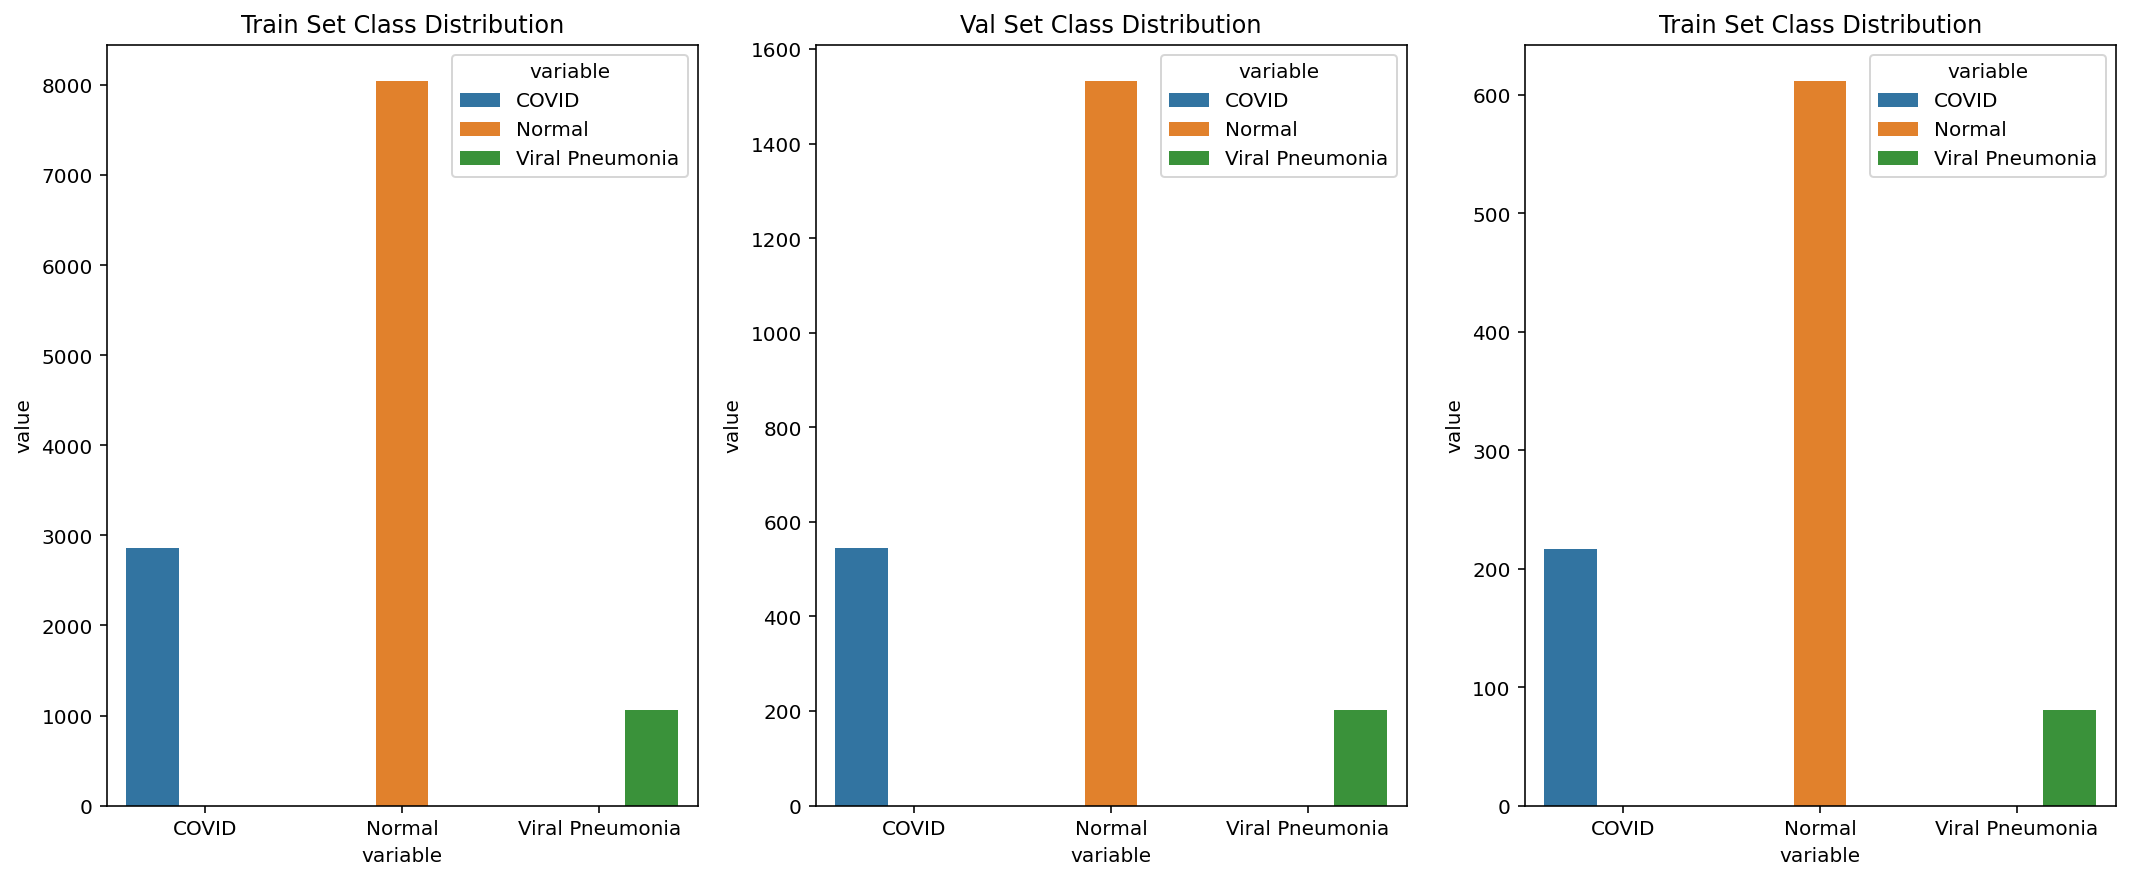

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))

sns.barplot(data = pd.DataFrame.from_dict([train_dist]).melt(), x = "variable", y="value", hue="variable", ax=axes[0]).set_title('Train Set Class Distribution')

sns.barplot(data = pd.DataFrame.from_dict([val_dist]).melt(), x = "variable", y="value", hue="variable",ax=axes[1]).set_title('Val Set Class Distribution')

sns.barplot(data = pd.DataFrame.from_dict([test_dist]).melt(), x = "variable", y="value", hue="variable",ax=axes[2]).set_title('Train Set Class Distribution')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))

train = sns.barplot(data = pd.DataFrame.from_dict([train_dist]).melt(), x = "variable", y="value",  ax=axes[0], palette=sns.color_palette("Paired")).set_title('Train Set Class Distribution')
train.xlabel("Class", size=10)
train.ylabel("Quantity", size=10)

valid = sns.barplot(data = pd.DataFrame.from_dict([val_dist]).melt(), x = "variable", y="value", ax=axes[1], palette=sns.color_palette("Paired")).set_title('Val Set Class Distribution')
valid.xlabel("Class", size=10)
valid.ylabel("Quantity", size=10)

test = sns.barplot(data = pd.DataFrame.from_dict([test_dist]).melt(), x = "variable", y="value", ax=axes[2], palette=sns.color_palette("Paired")).set_title('Train Set Class Distribution')
test.xlabel("Class", size=10)
test.ylabel("Quantity", size=10)

In [ ]:
# Functions to create confusion matrix

def get_confusion_tensor(preds, targets):
  stacked = torch.stack(
      (
          torch.cat(targets, dim=0)
          ,torch.cat(preds, dim=0)
      )
      ,dim=1
  )
  cmt = torch.zeros(3,3, dtype=torch.int64)
  for p in stacked:
      tl, pl = p.tolist()
      cmt[int(tl), int(pl)] = cmt[int(tl), int(pl)] + 1
  return cmt

def plot_confusion_matrix(preds, targets, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  cm = get_confusion_tensor(preds, targets)

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, fontsize='large')
  plt.yticks(tick_marks, classes, fontsize='large')

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", fontsize='large', color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Three Conv-pool doubling filters

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#                 dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*25*25, 120)
        self.fc2 = nn.Linear(120, 3)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.conv1(x)
      print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      print("first pool: ",x.shape)
      x= self.conv2(x)
      print("conv2: ", x.shape)
      x = self.pool(F.relu(x))
      print("second pool: ",x.shape)
      x= self.conv3(x)
      print("conv3: ", x.shape)
      x = self.pool(F.relu(x))
      print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      print("FC1 ", x.shape)
      x = F.relu(x)
      print("relu fc1: ", x.shape)
      x = self.fc2(x)
      print("FC2 ", x.shape)
      x = F.relu(x)
      print("relu fc2: ", x.shape)
      return x




In [ ]:
def train_model(n_epochs, print_every):
  

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

  valid_loss_min = np.Inf
  loss_history=[]  
  correct_history=[]  
  val_loss_history=[]  
  val_correct_history=[]  
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(dataloader_train)
  for epoch in range(1, n_epochs+1):
      running_loss = 0.0
      correct = 0
      total=0
      print(f'Epoch {epoch}\n')
      for batch_idx, (data_, target_) in enumerate(dataloader_train):
          data_, target_ = data_.to(device), target_.to(device)
          optimizer.zero_grad()
          
          outputs = net(data_)
          loss = criterion(outputs, target_)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _,pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred==target_).item()
          total += target_.size(0)
          if (batch_idx) % print_every == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
      train_acc.append(100 * correct / total)
      train_loss.append(running_loss/total_step)
      print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
      batch_loss = 0
      total_t=0
      correct_t=0
      with torch.no_grad():
          net.eval()
          for data_t, target_t in (dataloader_valid):
              data_t, target_t = data_t.to(device), target_t.to(device)
              outputs_t = net(data_t)
              loss_t = criterion(outputs_t, target_t)
              batch_loss += loss_t.item()
              _,pred_t = torch.max(outputs_t, dim=1)
              correct_t += torch.sum(pred_t==target_t).item()
              total_t += target_t.size(0)
          val_acc.append(100 * correct_t/total_t)
          val_loss.append(batch_loss/len(dataloader_valid))
          network_learned = batch_loss < valid_loss_min
          print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

          
          if network_learned:
              valid_loss_min = batch_loss
              torch.save(net.state_dict(), dir_path+'/'+str(n_epochs)+'_epoch_base.pt')
              print('Improvement-Detected, save-model')

      epoch_loss=running_loss/len(dataloader_train)
      epoch_acc=correct/total
      loss_history.append(epoch_loss)
      correct_history.append(epoch_acc)
      val_epoch_loss=batch_loss/len(dataloader_valid)
      val_epoch_acc=correct_t/total_t
      val_loss_history.append(val_epoch_loss)
      val_correct_history.append(val_epoch_acc)
      net.train()
  return loss_history, val_loss_history, train_acc, val_acc